## VaR y ES usando modelos EWMA y GARCH

Modelos volatilidad condicional: EWMA y GARCH

EWMA: λ = 0.94 (RiskMetrics).


$$\sigma_{t}^{2}=\lambda \sigma_{t-1}^{2}+(1-\lambda)r_{t-1}^{2} = (1-\lambda)\sum_{t=1}^{n}{\lambda^{t-1} r_{t}^{2}} $$

GARCH(1,1) usando arch_model() en Python.

$$\sigma_{t}^{2}= \omega + \alpha_i ɛ_{t-1}^2 + \beta \sigma_{t-1}^{2}$$



In [ ]:
!pip install --q arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 11.4 MB/s eta 0:00:00


In [ ]:
import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt
import cvxpy as cp  # Convex Optimization - Optimal Portfolio
from arch import arch_model   # ARCH-GARCH Models
import statsmodels.api as sm  # Modelos estadisticos y de regresion
from scipy.stats import norm, chi2, t
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Descarga de informacion / periodo compelto
acciones = ["AAPL", "HD", "MCD", "MMM"]
start = "2019-09-01"
end = "2025-09-26"
# Descargar precios de las acciones
precios = yf.download(acciones, start=start, end=end)["Close"]   # Periodo total de analisis
retornos = np.log(precios / precios.shift(1)).dropna()           # Para retornos dicsretos: data.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [ ]:
# Información de periodo de estimación para crear el portafolio y parametros (solo periodo dentro de muestra)
start_port = start    # Fecha inicial - portafolio
end_port   = "2024-09-26"     # Fecha final  - portafolio. Se deja el ultimo año para el backtest

retornos_port = retornos.loc[start_port:end_port]  # Informacion de retornos para crear el portafolio
mu = retornos_port.mean().values                   # Retornos esperados diarios
cov = retornos_port.cov().values                   # Matriz de covarianzas
t_port = len(retornos_port)

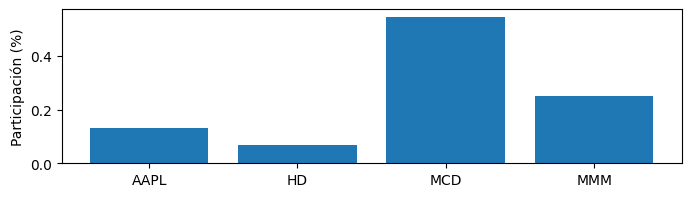

In [ ]:
# Optimizacion: Portafolio de minima varianza de Markowtiz
n = len(acciones)
w = cp.Variable(n)  # Se define el vector de incognitas: w
objectivo = cp.Minimize(cp.quad_form(w, cov))
restricciones = [w >= 0, w.sum()==1]
problema = cp.Problem(objectivo, restricciones)
problema.solve()
wp = w.value
plt.figure(figsize = (8, 2))
plt.bar(acciones, wp)
plt.ylabel("Participación (%)");

In [ ]:
# Calculos para el mismo periodo
port_rets = (retornos_port @ wp)

In [ ]:
## Funciones para el calculo del VaR y ES
# -------------------------------
# VaR parametrico (Normal)
def var_parametrico(rets, alpha):
    return np.mean(rets) + norm.ppf(1-alpha) * np.std(rets)
# -------------------------------
# ES parametrico
def es_parametrico(rets, alpha):
    return np.mean(rets) - np.std(rets) * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
# -------------------------------
# VaR historico
def var_historico(rets, alpha):
    return np.percentile(rets, 100*(1-alpha))
# -------------------------------
# ES historico
def es_historico(rets, alpha):
    var = np.percentile(rets, 100*(1-alpha))
    return rets[rets < var].mean()

In [ ]:
alpha = 0.99
var_hist = var_historico(port_rets, alpha)
var_par = var_parametrico(port_rets, alpha)
print(f"VaR historico: {var_hist:.4f}")
print(f"VaR parametrico: {var_par:.4f}")

VaR historico: -0.0341
VaR parametrico: -0.0304


In [ ]:
es_hist = es_historico(port_rets, alpha)
es_par = es_parametrico(port_rets, alpha)
print(f"ES historico: {es_hist:.4f}")
print(f"ES parametrico: {es_par:.4f}")

ES historico: -0.0586
ES parametrico: -0.0349


## Modelo EWMA

Calcular la varianza EWMA con la fórmula recursiva:

$$ \sigma_t^2 = λ \sigma_{t-1}^2+(1-λ)r_{t-1}^2 $$

donde: $λ$ suele ser 0.94 (RiskMetrics)

In [ ]:
# Volatilidad EWMA usando .pd
lambd = 0.94
rets_sq = port_rets.loc[start_port:end_port]**2
sigma2 = rets_sq.ewm(lambd).mean()   # Aqui se usa la funcion EWMA de la libreria pd, pero se puede modelar
sigma_ewma = np.sqrt(sigma2)

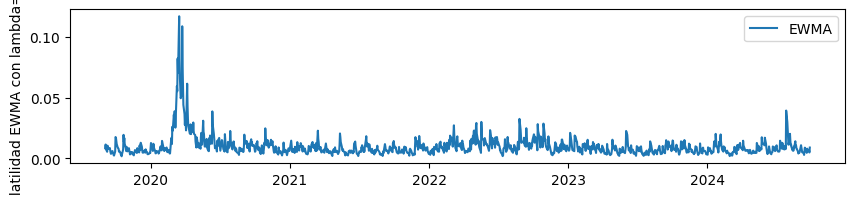

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(sigma_ewma,label="EWMA")
plt.ylabel('Volatilidad EWMA con lambda=0.94')
plt.legend();

In [ ]:
def model_ewma(y, lambd):
    """
    Modelo de volatilidad EWMA.
    Parámetros:
    y : Serie de retornos o pérdidas.
    lambd : Parámetro lambda para EWMA (ej: 0.94).
    """
    #y = np.asarray(y)
    y = y.values
    n = len(y)
    var_ewma = np.zeros(n)
    var_ewma[0] = np.var(y)  # primer valor | iniciar con la varianza muestral
    for t in range(1, n):
        var_ewma[t] = lambd * var_ewma[t-1] + (1 - lambd) * y[t-1]**2
    mu = np.mean(y)
    sigma_t = np.sqrt(var_ewma[-1])  # ultima volatilidad (predicción actual)
    return sigma_t

In [ ]:
#model_ewma(port_rets, lambd), port_rets.std()

In [ ]:
# Calculo del VaR/ES usando EWMA
sigma_ewma_m = model_ewma(port_rets, lambd)        # Calcula la volatilidad EWMA usando la funcion creada
var_ewma = np.mean(port_rets) + norm.ppf(1-alpha) * sigma_ewma_m                       # antes: np.std(port_rets)
es_ewma = np.mean(port_rets) - norm.pdf(norm.ppf(alpha)) / (1 - alpha) * sigma_ewma_m  # np.std(port_rets)
print(f"VaR param. EWMA: {var_ewma:.4f}")
print(f"ES param. EWMA: {es_ewma:.4f}")

VaR param. EWMA: -0.0186
ES param. EWMA: -0.0214


**Backtest usando la volatilidad EWMA**

In [ ]:
#bt_rets_p = port_rets.loc[start_bt:end_bt]
start_bt  = "2024-09-27"     # Fecha inicial backtest
end_bt    = "2025-09-26"
port_test = retornos.loc[start_bt:end_bt] @ wp

In [ ]:
#port_all[i-t_in:i]

In [ ]:
port_all = retornos @ wp
t_in = len(port_rets)
t_test = len(port_test)
t_all = len(port_all)
#t_in, t_all, t_test

var_backtest_ewma = []
es_backtest_ewma = []

for i in range(t_in, t_all):
  rets_port_t = port_all[i-250:i]
  # Calculo de la volatilidad EWMA
  sigma_ewma_t = model_ewma(rets_port_t, lambd)      # Pronostico a un dia
  var_backtest_ewma.append( np.mean(rets_port_t) + norm.ppf(1-alpha) * sigma_ewma_t )
  es_backtest_ewma.append( np.mean(rets_port_t) - norm.pdf(norm.ppf(alpha)) / (1 - alpha) * sigma_ewma_t )

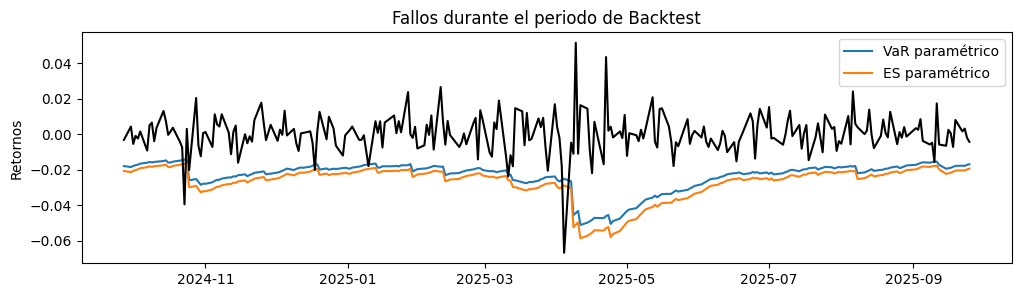

In [ ]:
# Backtest
plt.figure(figsize = (12, 3))
plt.plot(port_test.index,var_backtest_ewma,label='VaR paramétrico')
plt.plot(port_test.index,es_backtest_ewma,label='ES paramétrico')
plt.plot(port_test.index,port_test.values,color="k")
plt.title('Fallos durante el periodo de Backtest')
plt.ylabel('Retornos')
plt.legend();

### Conteo de los fallos o excepciones: $r_t < VaR/ES$

In [ ]:
print(port_test[port_test < var_backtest_ewma])
print(port_test[port_test < es_backtest_ewma])

Date
2024-10-23   -0.039430
2024-12-18   -0.020091
2025-01-10   -0.017838
2025-03-11   -0.023702
2025-04-04   -0.066693
2025-09-10   -0.015570
dtype: float64
Date
2024-10-23   -0.039430
2024-12-18   -0.020091
2025-04-04   -0.066693
dtype: float64


## Modelo GARCH(1,1)

In [ ]:
# modelo_garch = arch_model(port_rets*100, vol='Garch', p=1, q=1)
# resultado_garch = modelo_garch.fit(disp="off")
# print(resultado_garch.summary())

In [ ]:
# Pronóstico GARCH (volatilidad)
# forecast_garch = resultado_garch.forecast(horizon=10)
# volat_forecast = np.sqrt(forecast_garch.variance.values[-1,:]/10000)
# volat_forecast

In [ ]:
# GARCH(1,1)
model_garch = arch_model(port_rets*100, vol="GARCH", p=1,q=1)
res = model_garch.fit(disp="off")
sigma_garch = res.conditional_volatility/100

In [ ]:
# vol_forecasted = res.forecast(horizon=1)
# np.sqrt(vol_forecasted.variance.values[-1]/10000)

**Comparación de las voaltilidades estimadas**

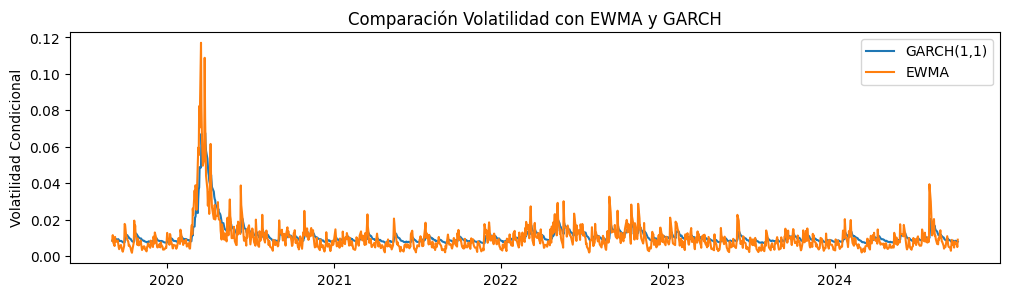

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(sigma_garch,label="GARCH(1,1)")
plt.plot(sigma_ewma,label="EWMA")
plt.ylabel('Volatilidad Condicional')
plt.title('Comparación Volatilidad con EWMA y GARCH')
plt.legend();

In [ ]:
# Calculo del VaR y ES usando GARCH (usando el promedio historico)
sigma_garch_m = sigma_garch.mean()      # Se calcula la vol. GARCH historica
var_garch = np.mean(port_rets) + norm.ppf(1-alpha) * sigma_garch_m                       # antes: np.std(port_rets)
es_garch = np.mean(port_rets) - norm.pdf(norm.ppf(alpha)) / (1 - alpha) * sigma_garch_m  # np.std(port_rets)
print(f"VaR param. GARCH: {var_garch:.4f}")
print(f"ES param. GARCH: {es_garch:.4f}")

VaR param. GARCH: -0.0253
ES param. GARCH: -0.0290


Comparación con EWMA:

In [ ]:
print(f"VaR param. EWMA: {var_ewma:.4f}")
print(f"ES param. EWMA: {es_ewma:.4f}")

VaR param. EWMA: -0.0186
ES param. EWMA: -0.0214


**Backtest para el siguiente año - usando la volatilidad EWMA**

In [ ]:
var_backtest_garch = []
es_backtest_garch = []

for i in range(t_in, t_all):
  rets_port_t = port_all[i-250:i]
  # Calculo de la volatilidad GARCH
  model_garch = arch_model(rets_port_t*100, vol="GARCH", p=1,q=1)
  res = model_garch.fit(disp="off")
  forecast = res.forecast(horizon=1)                                            # Pronostico a un dia
  sigma_garch_t = np.sqrt(forecast.variance.values[-1]/10000)                   # loc:[-1, 0]
  var_backtest_garch.append( np.mean(rets_port_t) + norm.ppf(1-alpha) * sigma_garch_t )
  es_backtest_garch.append( np.mean(rets_port_t) - norm.pdf(norm.ppf(alpha)) / (1 - alpha) * sigma_garch_t )
## ----------------------------------------------------------------------------------------------------------
## Nota: Como se multiplicar rets_port_t*100 para expresarlo en % (como lo requiere arch_model), para devolver
## la varianza, se divide la salida en 10000 para volver a unidades decimales (ya que son unidades al cuadrado).

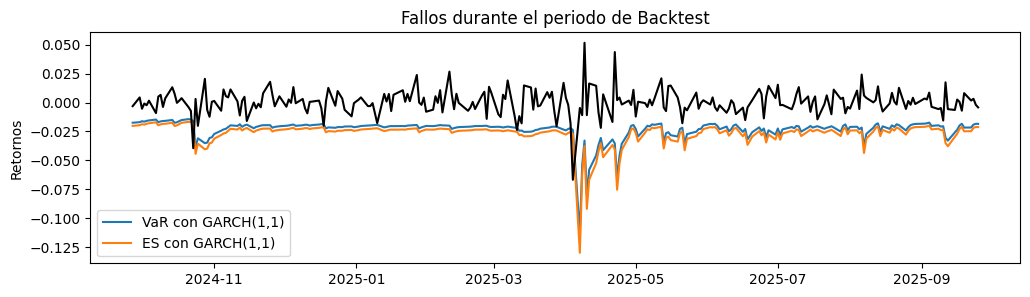

In [ ]:
# Modelo parametrico
plt.figure(figsize = (12, 3))
plt.plot(port_test.index,var_backtest_garch,label='VaR con GARCH(1,1)')
plt.plot(port_test.index,es_backtest_garch,label='ES con GARCH(1,1)')
plt.plot(port_test.index,port_test.values,color="k")
plt.title('Fallos durante el periodo de Backtest')
plt.ylabel('Retornos')
plt.legend()
plt.legend();

GARCH con otras funciones de distribución
----
**Propuesta:** modelo ES-GARCH t-student

In [ ]:
# -------------------------------------------
# Función ES-garch con distribucion t-student
def ESgarch_t(y, p):
    """
    Calcula el Expected Shortfall (ES) al nivel p usando GARCH(1,1)
    con distribución t-student.
    """
    # Ajustar modelo GARCH(1,1) con distribución t-student
    am = arch_model(y, vol='GARCH', p=1, q=1, dist='t', mean='zero')
    res = am.fit(disp='off')

    # Sigma pronosticada para un paso adelante
    forecast = res.forecast(horizon=1, reindex=False)
    sigma = np.sqrt(forecast.variance.values[-1, 0])  # sigma predicho
    # Grados de libertad de la t
    df = res.params['nu']
    # Quantil t
    q_t = t.ppf(p, df)
    # Fórmula ES (igual que en R)
    ES = sigma * (t.pdf(q_t, df) / (1 - p)) * ((df + q_t**2) / (df - 1))
    return ES
    # Incluir el VaR para realizar comparaciones

In [ ]:
ES_garch_ts = []
dates = []

for i in range(t_in, t_all):
    rets_port_t = port_all[i-250:i]
    es_val = ESgarch_t(rets_port_t, 1-alpha)
    ES_garch_ts.append(-np.sqrt(es_val))

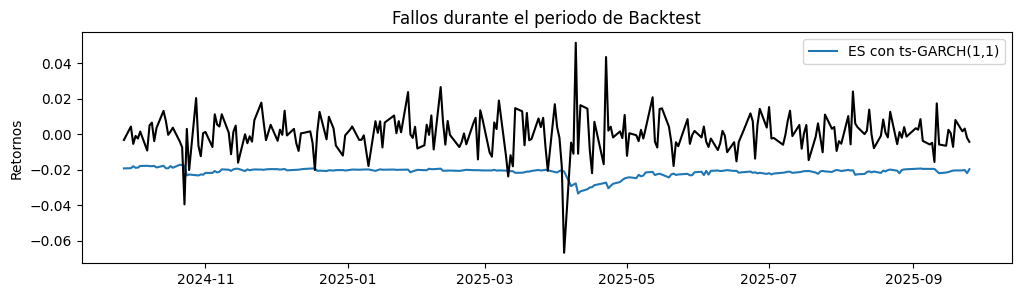

In [ ]:
# Modelo parametrico ts-GARCH(1,1)
plt.figure(figsize = (12, 3))
plt.plot(port_test.index,ES_garch_ts,label='ES con ts-GARCH(1,1)')
plt.plot(port_test.index,port_test.values,color="k")
#plt.plot(var_garch_ts,label='VaR usando GARCH')       # Incluir cuando se calcule el VaR
plt.title('Fallos durante el periodo de Backtest')
plt.ylabel('Retornos')
plt.legend();

**Tarea: ¿Cuántos fallos se presentan para el VaR usando el modelo ts-GARCH(1,1)?**

Extensiones importantes del algoritmo
---
1. Optimizar el parametro lambda para el modelo EWMA
2. Estimar un mejor modelo GARCH(p,q). Se pueden usar criterios de información como AIC o BIC para escoger un mejor modelo.
Cómo alternativa también se pueden usar métricas de error: MSE, MAE, MAPE.

## Selección del mejor modelo GARCH(p,q)

In [ ]:
# Finding the best GARCH model using information criteria.
best_aic = np.inf
best_bic = np.inf
best_model = None

p_range = range(1, 5)
q_range = range(1, 5)

for p in p_range:
    for q in q_range:
        try:
            # Fitting the GARCH model
            model = arch_model(port_rets*100, p=p, q=q, mean='constant', dist='Normal')
            model_fit = model.fit(disp='off')

            # Checking if the model has a lower AIC or BIC than the current best
            if model_fit.aic < best_aic or model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_model = model_fit
                best_params = (p, q)

        except Exception as e:
            print(f"Could not fit GARCH({p},{q}) model: {str(e)}")

# Best model's parameters and criteria
print(f"Best Model: GARCH({best_params[0]},{best_params[1]})")
print(f"Best AIC: {best_aic}")
print(f"Best BIC: {best_bic}")

Best Model: GARCH(2,1)
Best AIC: 3704.5229406288477
Best BIC: 3730.2764479168104


In [ ]:
#print(best_model.summary())

### Estimaciones para el periodo Sept-2019 a Sept-2024

In [ ]:
# GARCH(2,1)
best_model_garch = arch_model(port_rets*100, vol="GARCH", p=2,q=1)
best_res = best_model_garch.fit(disp="off")
best_sigma_garch = best_res.conditional_volatility/100

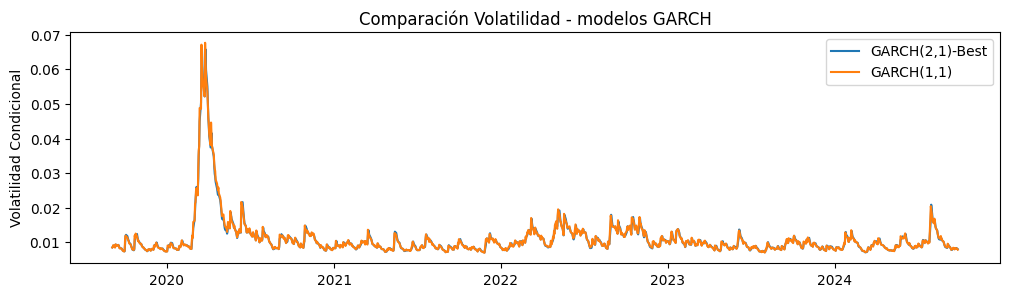

In [ ]:
# Comparación Volatilidad - modelos GARCH: GARCH(2,1) vs. GARCH(1,1)
plt.figure(figsize=(12,3))
plt.plot(best_sigma_garch,label="GARCH(2,1)-Best")
plt.plot(sigma_garch,label="GARCH(1,1)")
plt.ylabel('Volatilidad Condicional')
plt.title('Comparación Volatilidad - modelos GARCH')
plt.legend();

In [ ]:
# Calculo del VaR y ES usando GARCH(1,1) y GARCH(2,1) (usando el promedio historico)
best_sigma_garch_m = best_sigma_garch.mean()
var_garch_best = np.mean(port_rets) + norm.ppf(1-alpha) * best_sigma_garch_m
es_garch_best = np.mean(port_rets) - norm.pdf(norm.ppf(alpha)) / (1 - alpha) * best_sigma_garch_m
print(f"VaR param. GARCH(1,1): {var_garch:.4f}")
print(f"VaR param. GARCH(2,2): {var_garch_best:.4f}")
print(f"ES param. GARCH(1,1): {es_garch:.4f}")
print(f"ES param. GARCH(2,2): {es_garch_best:.4f}")

VaR param. GARCH(1,1): -0.0253
VaR param. GARCH(2,2): -0.0252
ES param. GARCH(1,1): -0.0290
ES param. GARCH(2,2): -0.0289


## Backtest - mejor modelo GARCH

In [ ]:
var_backtest_garch2 = []
es_backtest_garch2 = []
for i in range(t_in, t_all):
  rets_port_t = port_all[i-250:i]
  # Calculo de la volatilidad GARCH
  model_garch = arch_model(rets_port_t*100, vol="GARCH", p=2,q=1)
  res = model_garch.fit(disp="off")
  forecast = res.forecast(horizon=1)  # Pronostico a un dia
  sigma_garch2 = np.sqrt(forecast.variance.values[-1]/10000)
  var_backtest_garch2.append( np.mean(rets_port_t) + norm.ppf(1-alpha) * sigma_garch2 )
  es_backtest_garch2.append( np.mean(rets_port_t) - norm.pdf(norm.ppf(alpha)) / (1 - alpha) * sigma_garch2 )
## ----------------------------------------------------------------------------------------------------------

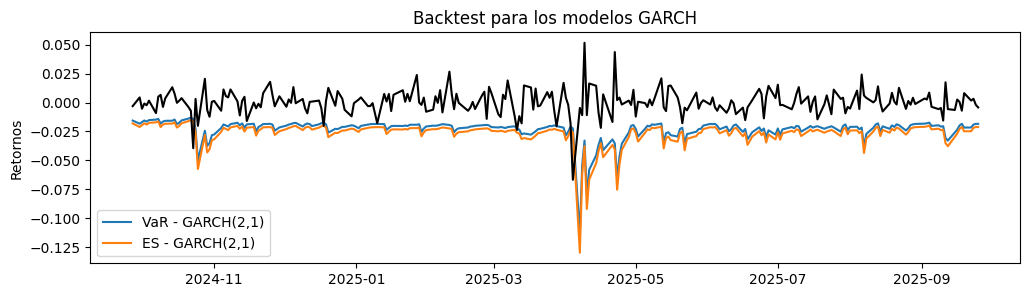

In [ ]:
# Comparacion VaR y ES - GARCH(2,1)
plt.figure(figsize = (12, 3))
plt.plot(port_test.index,var_backtest_garch2,label='VaR - GARCH(2,1)')
plt.plot(port_test.index,es_backtest_garch2,label='ES - GARCH(2,1)')
plt.plot(port_test.index,port_test.values,color="k")
plt.title('Backtest para los modelos GARCH')
plt.ylabel('Retornos')
plt.legend();

In [ ]:
# End....